# Text Classification

In [1]:
%%capture
!pip install wordcloud==1.9.3

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.kernel_approximation import RBFSampler
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('processed_reviews.csv')
df

,Summary,Text,Score,Y
0,Good Quality Dog Food,"['buy', 'several', 'vitality', 'can', 'dog', '...",5,1
1,Not as Advertised,"['arrive', 'label', 'jumbo', 'salt', 'peanutst...",1,0
2,"""Delight"" says it all","['confection', 'around', 'century', 'light', '...",4,1
3,Cough Medicine,"['look', 'secret', 'ingredient', 'robitussin',...",2,0
4,Great taffy,"['great', 'taffy', 'great', 'price', 'wide', '...",5,1
...,...,...,...,...
393665,Will not do without,"['great', 'sesame', 'chickenthis', 'good', 'no...",5,1
393666,disappointed,"['disappoint', 'flavor', 'chocolate', 'note', ...",2,0
393667,Perfect for our maltipoo,"['star', 'small', 'give', 'one', 'train', 'ses...",5,1
393668,Favorite Training and reward treat,"['best', 'treat', 'train', 'reward', 'dog', 'g...",5,1


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['Text'], 
                                                    df['Y'], 
                                                    test_size=0.30,
                                                    random_state=42, 
                                                    stratify=df['Y'])

In [5]:
X_train.shape, X_test.shape

((275569,), (118101,))

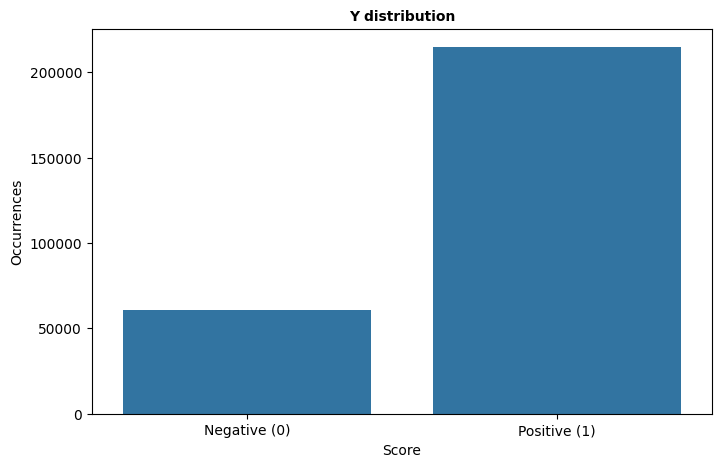

In [6]:
plt.figure(figsize=(8,5))
sns.countplot(x = y_train)

plt.title("Y distribution", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Occurrences")
plt.xticks(np.arange(0,2,1), ['Negative (0)', 'Positive (1)'])
plt.show()

In [7]:
df.Y.value_counts()

1    306814
0     86856
Name: Y, dtype: int64

### Class balancing

Undersampling procedure:

In [8]:
min_class_count = y_train.value_counts().min()

indices_to_drop = []

for class_label in y_train.unique():
    class_indices = y_train[y_train == class_label].index
    if len(class_indices) > min_class_count:
        indices_to_drop.extend(np.random.choice(class_indices,
                                                size=len(class_indices) - min_class_count,
                                                replace=False))
                                                
y_train_b = y_train.drop(indices_to_drop)
X_train_b = X_train.drop(indices_to_drop)

In [9]:
X_train_b.shape

(121598,)

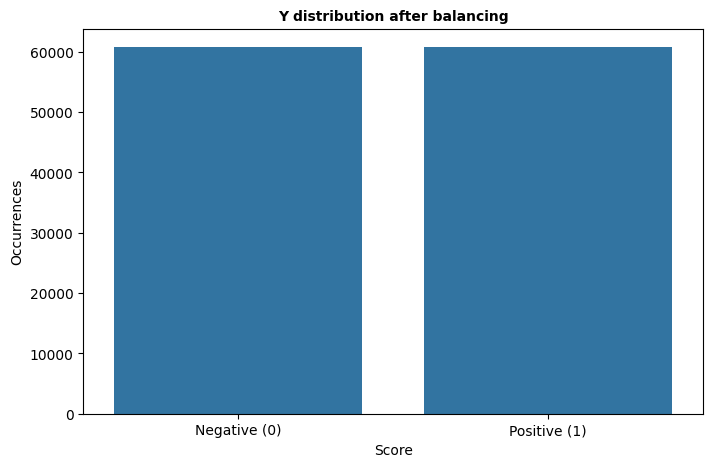

In [10]:
plt.figure(figsize=(8,5))
sns.countplot(x = y_train_b)

plt.title("Y distribution after balancing", fontweight='bold', fontsize=10)
plt.xlabel("Score")
plt.ylabel("Occurrences")
plt.xticks(np.arange(0,2,1), ['Negative (0)', 'Positive (1)'])
plt.show()

In [11]:
y_train_b.value_counts()

0    60799
1    60799
Name: Y, dtype: int64

### The length of the reviews

Distribution of the length of the reviews.
A **KDE plot** is a non-parametric way to estimate the probability density function of a random variable. It provides a smooth curve that represents the distribution of the data.

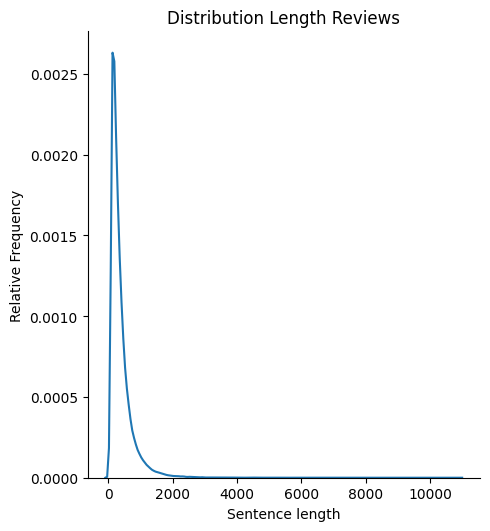

In [12]:
sns.displot([len(s) for s in X_train_b], kind='kde')
plt.title('Distribution Length Reviews')
plt.ylabel("Relative Frequency")
plt.xlabel("Sentence length")
plt.show()

## Text representation

### BOW (Count Vectorizer)

In [13]:
beta = 0.001

In [14]:
# min_df=beta=0.001 indica che un termine deve comparire in almeno 122 documenti per essere incluso nel vocabolario
# si utilizza X_train_b.astype(str) per assicurarsi che i testi siano trattati come stringhe

vect_bow = CountVectorizer(min_df = beta).fit(X_train_b)

print("Some sample features (unique words in the corpus):", vect_bow.get_feature_names_out()[0:15])

Some sample features (unique words in the corpus): ['ability' 'able' 'absolute' 'absolutely' 'absorb' 'acai' 'accept'
 'acceptable' 'access' 'accident' 'accidentally' 'accord' 'account'
 'accurate' 'accustom']


In [15]:
X_train_cv = vect_bow.transform(X_train_b)
X_train_cv.shape

(121598, 2891)

In [16]:
X_test_cv = vect_bow.transform(X_test)
X_test_cv.shape

(118101, 2891)

In [17]:
print(f'Unique words - CountVect: {X_train_cv.shape[1]}')
print(f'Min value in bow matrix - CountVect: {X_train_cv.min()}')
print(f'Max value in bow matrix - CountVect: {X_train_cv.max()}')

Unique words - CountVect: 2891
Min value in bow matrix - CountVect: 0
Max value in bow matrix - CountVect: 63


### TF-IDF

In [18]:
vect_tfidf = TfidfVectorizer(min_df = beta).fit(X_train_b)
# anche in questo caso un termine deve comparire in almeno 122 documenti

In [19]:
print("Some sample features (unique words in the corpus): ", vect_tfidf.get_feature_names_out()[0:15])

Some sample features (unique words in the corpus):  ['ability' 'able' 'absolute' 'absolutely' 'absorb' 'acai' 'accept'
 'acceptable' 'access' 'accident' 'accidentally' 'accord' 'account'
 'accurate' 'accustom']


In [20]:
X_train_tfidf = vect_tfidf.transform(X_train_b)
X_train_tfidf.shape

(121598, 2891)

In [21]:
X_test_tfidf = vect_tfidf.transform(X_test)
X_test_tfidf.shape

(118101, 2891)

In [22]:
print(f"Unique words - TfIdf: {X_test_tfidf.shape[1]}")
print(f"Min value in bow matrix - TfIdf: {X_test_tfidf.min():.2f}")
print(f"Max value in bow matrix - TfIdf: {X_test_tfidf.max():.2f}")

Unique words - TfIdf: 2891
Min value in bow matrix - TfIdf: 0.00
Max value in bow matrix - TfIdf: 1.00


## Classification metrics

In [23]:
def evaluate_prediction(clf, X, y, t_names = ['Negative', 'Positive']):
    
  y_pred = np.round(clf.predict(X))
  print(classification_report(y_pred, y, target_names=t_names))

  if str(X)[:5] == str(X_test) or str(X) == str(X_test_tfidf):
    cm = confusion_matrix(y_pred, y)

    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', cmap="BuPu")
    ax.set_xticklabels(t_names)
    ax.set_yticklabels(t_names)
    ax.set_xlabel('True labels')
    ax.set_ylabel('Predicted labels')
    ax.set_title('Confusion Matrix')

  false_positive_indices = np.where((y_pred == 1) & (y == 0))[0]
  false_negative_indices = np.where((y_pred == 0) & (y == 1))[0]

  return y_pred, false_positive_indices, false_negative_indices

In [24]:
def show_most_informative_features(vectorizer, clf, n=20):
    
    feature_names = vectorizer.get_feature_names_out()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

## Logistic Regression model

### BOW

In [25]:
logreg_bow = LogisticRegression(max_iter=100, random_state=42)
logreg_bow = logreg_bow.fit(X_train_cv, y_train_b)

In [26]:
# SCORES ON TRAINING SET
_, false_positive_indices, false_negative_indices = evaluate_prediction(logreg_bow, X_train_cv, y_train_b)

              precision    recall  f1-score   support

    Negative       0.85      0.86      0.85     60173
    Positive       0.86      0.85      0.85     61425

    accuracy                           0.85    121598
   macro avg       0.85      0.85      0.85    121598
weighted avg       0.85      0.85      0.85    121598



In [27]:
# SCORES ON TEST SET
y_pred_logreg_bow, false_positive_indices, false_negative_indices = evaluate_prediction(logreg_bow,
                                                                                        X_test_cv,
                                                                                        y_test)

              precision    recall  f1-score   support

    Negative       0.84      0.61      0.71     35690
    Positive       0.85      0.95      0.90     82411

    accuracy                           0.85    118101
   macro avg       0.84      0.78      0.80    118101
weighted avg       0.85      0.85      0.84    118101



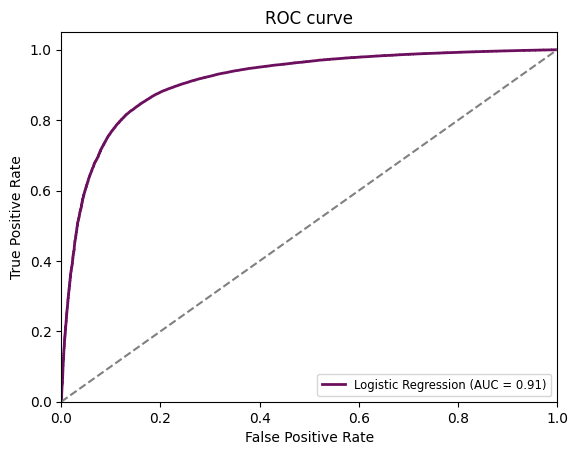

In [28]:
y_prob_log_bow = logreg_bow.predict_proba(X_test_cv)[:,1]
auc_log_bow = roc_auc_score(y_test, logreg_bow.predict_proba(X_test_cv)[:, 1])
fpr_log_bow, tpr_log_bow, _ = roc_curve(y_test, y_prob_log_bow)

plt.plot(fpr_log_bow, tpr_log_bow, color='#6c0f5e', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(auc_log_bow))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right', fontsize='small')
plt.show()

In [29]:
show_most_informative_features(vect_bow, logreg_bow)

	-2.2992	worst          		2.2212	skeptical      
	-2.1712	mediocre       		1.8513	yum            
	-2.1694	ripoff         		1.7530	pleasantly     
	-1.9160	disappointment 		1.6776	hook           
	-1.7250	concept        		1.4464	exceed         
	-1.6741	deceptive      		1.4345	bonus          
	-1.6179	terrible       		1.4334	grateful       
	-1.6091	unacceptable   		1.4124	highly         
	-1.5941	useless        		1.3892	whim           
	-1.5812	unfortunately  		1.3423	versatile      
	-1.5688	inedible       		1.3337	worry          
	-1.5212	dissapointed   		1.3289	delicious      
	-1.5161	awful          		1.3134	excellent      
	-1.5116	undrinkable    		1.2943	perfect        
	-1.5058	refund         		1.2459	beat           
	-1.4948	cancel         		1.2204	yummy          
	-1.4940	flavorless     		1.2163	shiny          
	-1.4856	horrid         		1.2002	fragrant       
	-1.4428	sadly          		1.1787	fabulous       
	-1.4030	horrible       		1.1667	terrific       


### TF-IDF

In [30]:
logreg_tfidf = LogisticRegression()
logreg_tfidf = logreg_tfidf.fit(X_train_tfidf, y_train_b)

In [31]:
# SCORES ON TRAINING SET
_, false_positive_indices, false_negative_indices = evaluate_prediction(logreg_tfidf, X_train_tfidf, y_train_b)

              precision    recall  f1-score   support

    Negative       0.86      0.85      0.86     61335
    Positive       0.85      0.86      0.85     60263

    accuracy                           0.85    121598
   macro avg       0.85      0.85      0.85    121598
weighted avg       0.85      0.85      0.85    121598



              precision    recall  f1-score   support

    Negative       0.85      0.61      0.71     36675
    Positive       0.84      0.95      0.89     81426

    accuracy                           0.85    118101
   macro avg       0.85      0.78      0.80    118101
weighted avg       0.85      0.85      0.84    118101



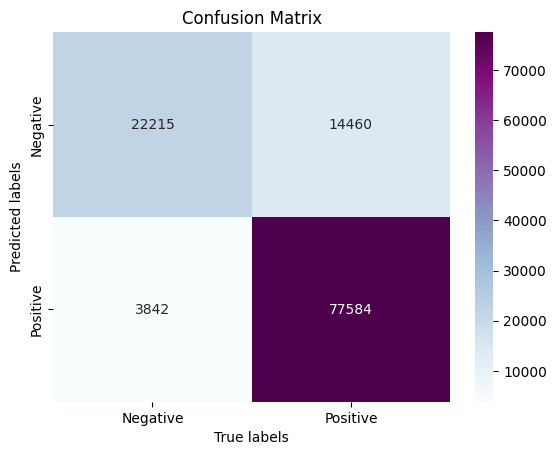

In [32]:
# SCORES ON TEST SET
y_pred_logreg_tfidf, false_positive_indices, false_negative_indices = evaluate_prediction(logreg_tfidf,
                                                                                        X_test_tfidf,
                                                                                        y_test)

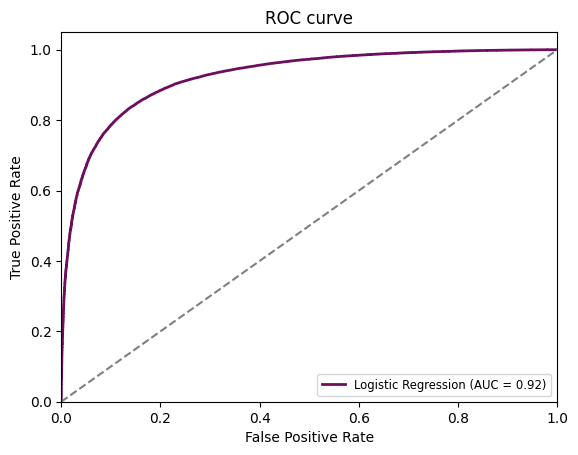

In [33]:
y_prob_log_tfidf = logreg_tfidf.predict_proba(X_test_tfidf)[:,1]
auc_log_tfidf = roc_auc_score(y_test, logreg_tfidf.predict_proba(X_test_tfidf)[:, 1])
fpr_log_tfidf, tpr_log_tfidf, _ = roc_curve(y_test, y_prob_log_tfidf)

plt.plot(fpr_log_tfidf, tpr_log_tfidf, color='#6c0f5e', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(auc_log_tfidf))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right', fontsize='small')
plt.show()

In [34]:
show_most_informative_features(vect_tfidf, logreg_tfidf)

	-8.6048	worst          		8.0957	great          
	-8.1193	not            		7.8637	delicious      
	-7.4042	disappoint     		7.7972	best           
	-6.9168	unfortunately  		7.3586	perfect        
	-6.3323	awful          		7.1820	highly         
	-6.3117	terrible       		6.6919	love           
	-6.2106	ok             		6.4849	excellent      
	-6.1036	disappointment 		5.9580	wonderful      
	-5.7171	horrible       		5.3517	amaze          
	-5.5307	hop            		5.2483	pleasantly     
	-5.3784	okay           		5.1460	hook           
	-5.2601	return         		5.1221	worry          
	-5.2480	refund         		4.9516	yummy          
	-4.9800	bland          		4.8125	awesome        
	-4.9669	stale          		4.7292	favorite       
	-4.6359	disgust        		4.6966	skeptical      
	-4.5133	however        		4.5070	glad           
	-4.1767	sadly          		4.5038	yum            
	-4.1295	cancel         		4.3586	happy          
	-4.1147	weak           		4.3576	smooth         


Looking for the common tokens in the False Positive

In [35]:
def lista_di_stringhe_a_stringa(lista):
    return ' '.join(eval(lista))

### Wordclouds

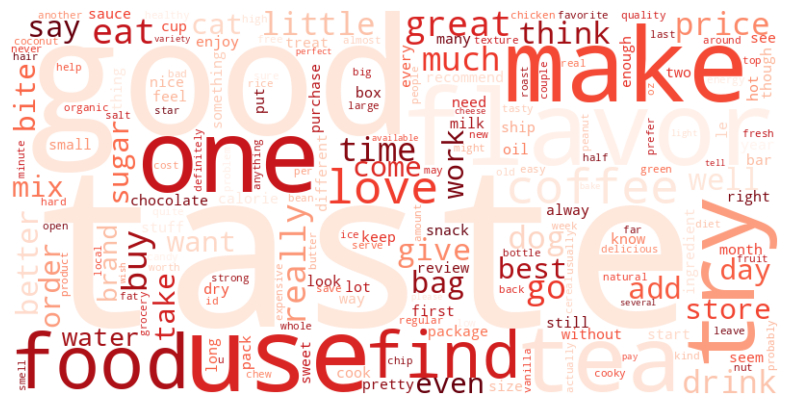

In [36]:
# FALSE POSITIVE prediction most common tokens

fp_feedback = ''.join(X_test.iloc[false_positive_indices].apply(lista_di_stringhe_a_stringa))
wordcloud_fp = WordCloud(width=800, height=400, background_color='white', colormap='Reds', random_state = 42, collocations = False).generate(fp_feedback)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fp, interpolation='bilinear')
plt.axis("off")
plt.show()

In [37]:
top_fp = dict(sorted(wordcloud_fp.words_.items(), key=lambda x: x[1], reverse=True)[:5])

print("Top 5 most frequent words:")
for word, frequency in top_fp.items():
    print(f"{word}")

Top 5 most frequent words:
taste
good
flavor
use
make


Looking for the common tokens in the False Negatives

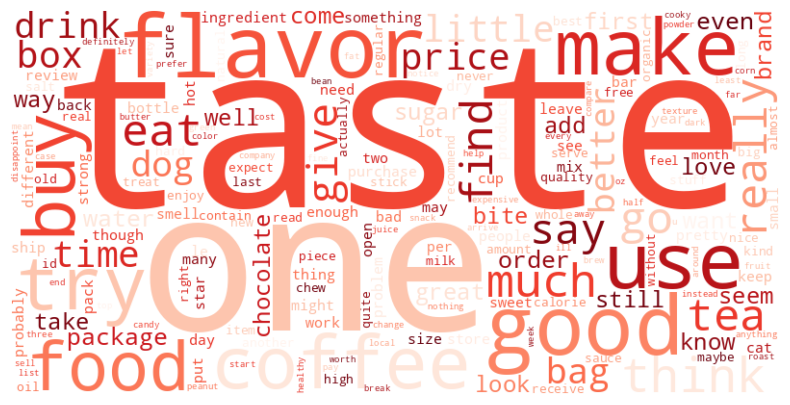

In [38]:
# FALSE NEGATIVE prediction most common tokens

fn_feedback = ''.join(X_test.iloc[false_negative_indices].apply(lista_di_stringhe_a_stringa))
wordcloud_fn = WordCloud(width=800, height=400, background_color='white', colormap='Reds', random_state = 42, collocations = False).generate(fn_feedback)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fn, interpolation='bilinear')
plt.axis("off")
plt.show()

In [39]:
top_fn = dict(sorted(wordcloud_fn.words_.items(), key=lambda x: x[1], reverse=True)[:5])

print("Top 5 most frequent words:")
for word, frequency in top_fn.items():
    print(f"{word}")

Top 5 most frequent words:
taste
one
flavor
good
use


In [40]:
# Calcolo gli indici delle predizioni errate
misclassified_indices = [i for i, (predicted, true) in enumerate(zip(y_pred_logreg_tfidf, y_test)) if predicted != true]

misclassified_tokenized_texts = X_test.iloc[misclassified_indices]

all_misclassified_tokens = ' '.join(misclassified_tokenized_texts.apply(lista_di_stringhe_a_stringa))

# Calcolo la frequenza dei token
token_frequencies = Counter(all_misclassified_tokens.split())

# Trovo i token più frequenti (ad esempio i primi 10)
most_common_tokens = token_frequencies.most_common(10)

print("Token più frequenti nelle misclassificazioni:")
for token, frequency in most_common_tokens:
    print(f"{token}: {frequency}")

Token più frequenti nelle misclassificazioni:
not: 29496
like: 11717
taste: 10112
good: 7316
get: 7315
one: 7185
flavor: 7156
use: 6336
make: 5874
try: 5773


## Random Forest model

### BOW

In [41]:
rf_bow = RandomForestClassifier(n_estimators=100, n_jobs=4, max_depth=10, random_state=42)
rf_bow = rf_bow.fit(X_train_cv, y_train_b)

In [42]:
# SCORES ON TRAINING SET
_, false_positive_indices, false_negative_indices = evaluate_prediction(rf_bow, X_train_cv, y_train_b)

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79     60192
    Positive       0.79      0.79      0.79     61406

    accuracy                           0.79    121598
   macro avg       0.79      0.79      0.79    121598
weighted avg       0.79      0.79      0.79    121598



In [43]:
y_pred_rf_bow, false_positive_indices, false_negative_indices = evaluate_prediction(rf_bow,
                                                                                    X_test_cv,
                                                                                    y_test)

              precision    recall  f1-score   support

    Negative       0.78      0.50      0.61     40584
    Positive       0.78      0.92      0.85     77517

    accuracy                           0.78    118101
   macro avg       0.78      0.71      0.73    118101
weighted avg       0.78      0.78      0.76    118101



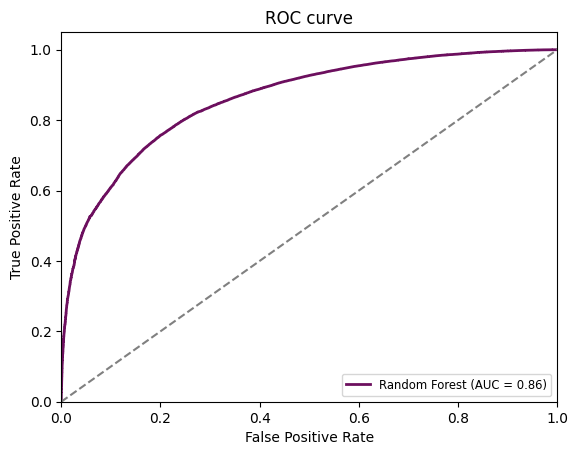

In [44]:
y_prob_rf_bow = rf_bow.predict_proba(X_test_cv)[:,1]
auc_rf_bow = roc_auc_score(y_test, rf_bow.predict_proba(X_test_cv)[:, 1])
fpr_rf_bow, tpr_rf_bow, _ = roc_curve(y_test, y_prob_rf_bow)

plt.plot(fpr_rf_bow, tpr_rf_bow, color='#6c0f5e', lw=2, label='Random Forest (AUC = {:.2f})'.format(auc_rf_bow))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right', fontsize='small')
plt.show()

In [45]:
importances = rf_bow.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = vect_bow.get_feature_names_out()

print("Top 10 Feature Importance:\n")
for f in range(10):
    print(f"{feature_names[indices[f]]}: {importances[indices[f]]}")

Top 10 Feature Importance:

not: 0.09138634270416965
disappoint: 0.04612409688167787
love: 0.045823794722426384
great: 0.042419121589158164
bad: 0.03828707137596566
best: 0.029025741678883187
delicious: 0.028282887704074135
perfect: 0.023417912559589412
taste: 0.02269891843389381
highly: 0.019944223469995085


### TF-IDF

In [46]:
rf_tfidf = RandomForestClassifier(n_estimators=100, n_jobs=4, max_depth=10, random_state=42)
rf_tfidf = rf_tfidf.fit(X_train_tfidf, y_train_b)

In [47]:
# SCORES ON TEST SET
_, false_positive_indices, false_negative_indices = evaluate_prediction(rf_tfidf, X_train_tfidf, y_train_b)

              precision    recall  f1-score   support

    Negative       0.79      0.79      0.79     61037
    Positive       0.79      0.79      0.79     60561

    accuracy                           0.79    121598
   macro avg       0.79      0.79      0.79    121598
weighted avg       0.79      0.79      0.79    121598



              precision    recall  f1-score   support

    Negative       0.78      0.49      0.60     41686
    Positive       0.77      0.93      0.84     76415

    accuracy                           0.77    118101
   macro avg       0.78      0.71      0.72    118101
weighted avg       0.77      0.77      0.76    118101



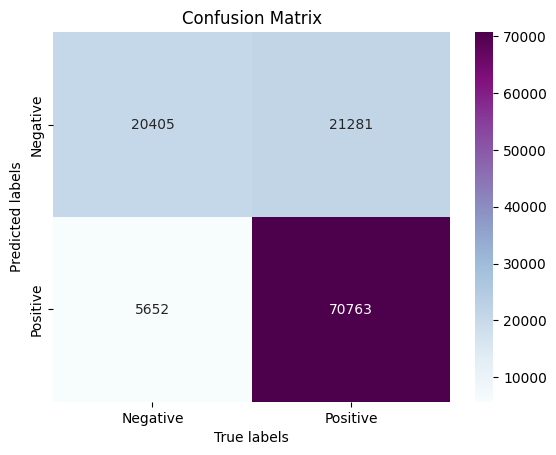

In [48]:
y_pred_rf_tfidf, false_positive_indices, false_negative_indices = evaluate_prediction(rf_tfidf,
                                                                                        X_test_tfidf,
                                                                                        y_test)

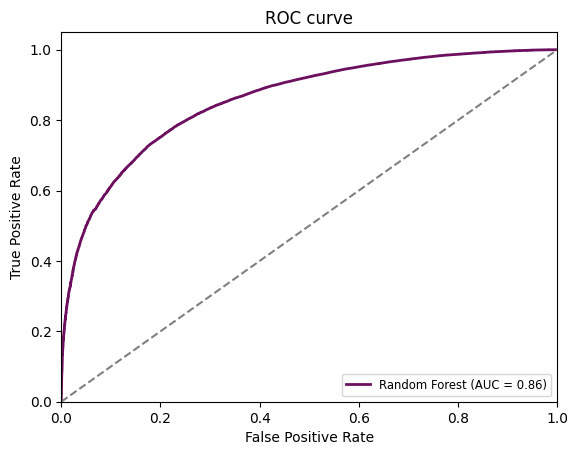

In [49]:
y_prob_rf_tfidf = rf_tfidf.predict_proba(X_test_tfidf)[:,1]
auc_rf_tfidf = roc_auc_score(y_test, rf_tfidf.predict_proba(X_test_tfidf)[:, 1])
fpr_rf_tfidf, tpr_rf_tfidf, _ = roc_curve(y_test, y_prob_rf_tfidf)

plt.plot(fpr_rf_tfidf, tpr_rf_tfidf, color='#6c0f5e', lw=2, label='Random Forest (AUC = {:.2f})'.format(auc_rf_tfidf))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right', fontsize='small')
plt.show()

In [50]:
importances = rf_tfidf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = vect_tfidf.get_feature_names_out()

print("Top 10 Feature Importance:\n")
for f in range(10):
    print(f"{feature_names[indices[f]]}: {importances[indices[f]]}")

Top 10 Feature Importance:

not: 0.09192051043655723
love: 0.051473129141861904
great: 0.04320700653535994
disappoint: 0.04224732552554333
bad: 0.037026251739276685
best: 0.03245010725265909
delicious: 0.028362660604560254
perfect: 0.02704625293310352
highly: 0.01809498161374149
return: 0.01571859863895822


## C-Support Vector model

### BOW

In [51]:
rbf_feature = RBFSampler(random_state = 42)
X_features = rbf_feature.fit_transform(X_train_cv)

svm = SGDClassifier(alpha=0.0001, eta0=0.1)
svm_bow = svm.fit(X_features, y_train_b)

In [52]:
# SCORES ON TRAINING SET
_, false_positive_indices, false_negative_indices = evaluate_prediction(svm_bow, X_features, y_train_b)

              precision    recall  f1-score   support

    Negative       0.70      0.51      0.59     84073
    Positive       0.32      0.52      0.40     37525

    accuracy                           0.51    121598
   macro avg       0.51      0.51      0.49    121598
weighted avg       0.59      0.51      0.53    121598



In [53]:
# SCORES ON TEST SET
y_pred_svm_bow, false_positive_indices, false_negative_indices = evaluate_prediction(svm_bow,
                                                                                     rbf_feature.transform(X_test_cv),
                                                                                     y_test)

              precision    recall  f1-score   support

    Negative       0.69      0.22      0.33     81643
    Positive       0.31      0.78      0.44     36458

    accuracy                           0.39    118101
   macro avg       0.50      0.50      0.39    118101
weighted avg       0.57      0.39      0.37    118101



In [54]:
show_most_informative_features(vect_bow, svm_bow)

	-1.1007	agent          		0.7898	achieve        
	-0.7171	activity       		0.7392	adopt          
	-0.6472	act            		0.7073	allergy        
	-0.6373	advise         		0.6991	acai           
	-0.5990	additionally   		0.6963	ad             
	-0.5545	although       		0.5852	aka            
	-0.5492	afraid         		0.5428	acceptable     
	-0.5351	acid           		0.4578	amount         
	-0.4868	air            		0.4526	american       
	-0.4525	aftertaste     		0.4339	additional     
	-0.4521	advice         		0.4061	america        
	-0.4497	action         		0.3981	afternoon      
	-0.4469	allow          		0.3937	aluminum       
	-0.4255	agree          		0.2990	amazon         
	-0.3969	adult          		0.2935	alot           
	-0.3698	almond         		0.2891	almost         
	-0.3581	additive       		0.2879	acidity        
	-0.3576	account        		0.2799	adjust         
	-0.3448	absolutely     		0.2737	access         
	-0.3347	accident       		0.2596	alert          


### TF-IDF

In [55]:
X_features = rbf_feature.fit_transform(X_train_tfidf)

svm_tfidf = svm.fit(X_features, y_train_b)

In [56]:
# SCORES ON TRAINING SET
_, false_positive_indices, false_negative_indices = evaluate_prediction(svm_tfidf, X_features, y_train_b)

              precision    recall  f1-score   support

    Negative       0.54      0.60      0.57     54512
    Positive       0.64      0.58      0.61     67086

    accuracy                           0.59    121598
   macro avg       0.59      0.59      0.59    121598
weighted avg       0.60      0.59      0.59    121598



In [57]:
# SCORES ON TEST SET
y_pred_svm_tfidf, false_positive_indices, false_negative_indices = evaluate_prediction(svm_tfidf,
                                                                                        rbf_feature.transform(X_test_tfidf),
                                                                                        y_test)

              precision    recall  f1-score   support

    Negative       0.54      0.30      0.39     47120
    Positive       0.64      0.83      0.72     70981

    accuracy                           0.62    118101
   macro avg       0.59      0.57      0.55    118101
weighted avg       0.60      0.62      0.59    118101



In [58]:
show_most_informative_features(vect_tfidf, svm_tfidf)

	-2.4740	air            		2.0067	ago            
	-1.9064	ability        		1.6249	advise         
	-1.6420	advantage      		1.5926	al             
	-1.5998	along          		1.0099	aka            
	-1.1483	alive          		1.0096	agree          
	-1.1373	among          		0.9965	ahoy           
	-1.1111	accident       		0.9425	address        
	-1.0581	accurate       		0.8824	additive       
	-1.0383	allergy        		0.8823	agave          
	-1.0380	alternate      		0.8306	acidic         
	-1.0220	acid           		0.7289	ala            
	-0.9937	agent          		0.7233	amazingly      
	-0.9924	always         		0.6782	act            
	-0.8755	adore          		0.6510	adult          
	-0.8632	adjust         		0.6012	add            
	-0.8433	addictive      		0.5898	american       
	-0.8358	acceptable     		0.5315	afraid         
	-0.7163	absorb         		0.5245	absolute       
	-0.7158	access         		0.5039	adequate       
	-0.6809	albeit         		0.5033	accept         


## NGRAMS

In [59]:
vect_tfidf_ngram = TfidfVectorizer(min_df = 0.001, ngram_range=(1,2)).fit(X_train_b)

In [60]:
X_train_vectorized = vect_tfidf_ngram.transform(X_train_b)

In [61]:
X_test_tfidf = vect_tfidf_ngram.transform(X_test)

In [62]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train_vectorized, y_train_b)

In [63]:
# SCORES ON TRAINING SET
_, false_positive_indices, false_negative_indices = evaluate_prediction(logreg, X_train_vectorized, y_train_b)

              precision    recall  f1-score   support

    Negative       0.88      0.88      0.88     61040
    Positive       0.88      0.88      0.88     60558

    accuracy                           0.88    121598
   macro avg       0.88      0.88      0.88    121598
weighted avg       0.88      0.88      0.88    121598



              precision    recall  f1-score   support

    Negative       0.86      0.64      0.74     35028
    Positive       0.86      0.96      0.91     83073

    accuracy                           0.86    118101
   macro avg       0.86      0.80      0.82    118101
weighted avg       0.86      0.86      0.86    118101



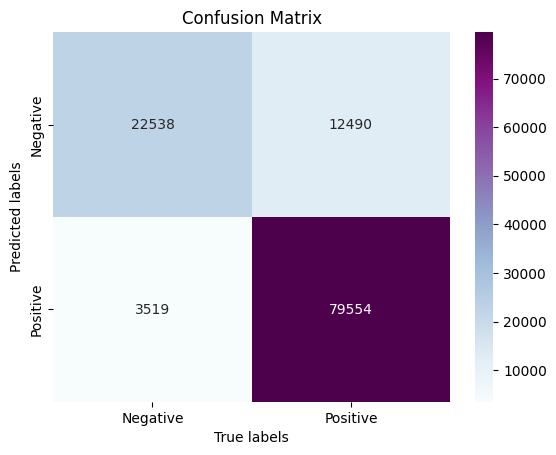

In [64]:
# SCORES ON TEST SET
y_pred_logreg_tfidf, false_positive_indices, false_negative_indices = evaluate_prediction(logreg,
                                                                                        X_test_tfidf,
                                                                                        y_test)

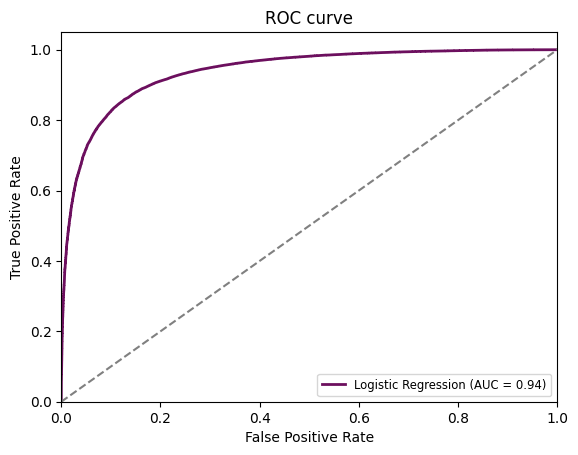

In [65]:
y_prob_log_tfidf = logreg.predict_proba(X_test_tfidf)[:,1]
auc_log_tfidf = roc_auc_score(y_test, logreg.predict_proba(X_test_tfidf)[:, 1])
fpr_log_tfidf, tpr_log_tfidf, _ = roc_curve(y_test, y_prob_log_tfidf)

plt.plot(fpr_log_tfidf, tpr_log_tfidf, color='#6c0f5e', lw=2, label='Logistic Regression (AUC = {:.2f})'.format(auc_log_tfidf))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right', fontsize='small')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=a1b052e0-2ae7-4808-9f70-51bfe2ee192f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>